# Ajuste de hiper-parámetros

Cuando trabajamos con modelos de *machine learning* a menudo nos encontramos con que estos disponen de una serie de hiper-parámetros que es necesario ajustar con el fin de lograr que realicen las predicciones más certeras posibles sobre nuestro conjunto de datos. A este paso se le conoce como **hyper-parameters tunning**.

Veamos cómo podemos ajustar los hiper-parámetros de un `RandomForestClassifier`para el conjunto de datos de las caras de Olivetti.

Cargamos las caras:

In [1]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [2]:
X = olivetti.data
y = olivetti.target

El conjunto de datos de las caras de Olivetti busca identificar a 40 personas mediante imágenes de sus rostros.

In [3]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

Algunas de las caras:

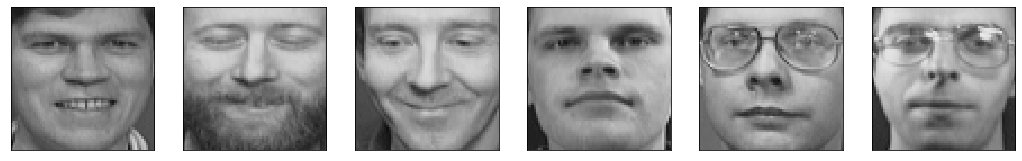

In [5]:
import matplotlib.pyplot as plt
import numpy as np

n_images = 6
image_shape = (64, 64)

random_indices = np.random.choice(X.shape[0], size=n_images, replace=False)
faces = X[random_indices, :]

fig, axs = plt.subplots(nrows=1, ncols=n_images, figsize=(3*n_images, 3))

for i, comp in enumerate(faces):
    axs[i].imshow(comp.reshape(image_shape), cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=1)
    axs[i].set_xticks(())
    axs[i].set_yticks(())

Prepramos el dataset y lo partimos en `train` y `test`:

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Optimización de un hiper-parámetro

Si quieremos optimizar un único híper-parametro, lo ideal es analizar cómo se comporta una medida de calidad según evoluciona dicho hiper-parámetro.

Por ejemplo, veamos como varía el *accuracy* al variar el hiper-parámetro `n_estimators`:

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Paralle

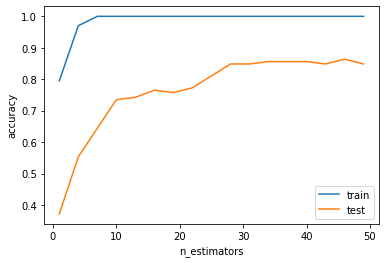

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

n_estimators = np.arange(1,50,3)
train_scores = np.array([])
test_scores = np.array([])

for n in n_estimators:
  clf = RandomForestClassifier(n_estimators=n, verbose=1, n_jobs=-1, random_state=42).fit(X_train, y_train)
  train_scores = np.append(train_scores, clf.score(X_train, y_train))
  test_scores = np.append(test_scores, clf.score(X_test, y_test))

plt.figure()

plt.plot(n_estimators, train_scores, label="train")
plt.plot(n_estimators, test_scores, label="test")

plt.xlabel('n_estimators')
plt.ylabel('accuracy')

plt.legend()

## Optimización de dos hiper-parámetros

Si queremos comprobar cómo evoluciona el error cuando para las variaciones producidas por dos hiper-parámetros, debemos pintar un mapa de calor en el que se muestre el resultado de evaluar el modelo para las combinaciones de calores de los dos hiper-parámetros.

Veamos como evoluciona el *accuracy* cuando variamos `n_estimators` y `max_depth`:

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=1)

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=1)

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=1)

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.6s finished
[Parallel(n_jobs=1)

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=1)

Text(0.5, 1.0, 'Test')

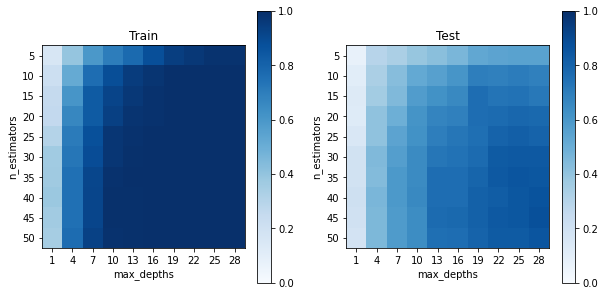

In [10]:
import matplotlib.pyplot as plt

n_estimators = np.arange(5,51,5)
max_depths = np.arange(1,30,3)

train_scores = np.array([])
test_scores = np.array([])

for n in n_estimators:
  for d in max_depths:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d, verbose=1, n_jobs=-1, random_state=42).fit(X_train, y_train)
    train_scores = np.append(train_scores, clf.score(X_train, y_train))
    test_scores = np.append(test_scores, clf.score(X_test, y_test))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# train error 

im0 = axs[0].imshow(train_scores.reshape((len(n_estimators), len(max_depths))), vmin=0, vmax=1, cmap='Blues')
plt.colorbar(im0, ax=axs[0])

axs[0].set_xlabel('max_depths')
axs[0].set_xticks(np.arange(len(max_depths)))
axs[0].set_xticklabels(max_depths)

axs[0].set_ylabel('n_estimators')
axs[0].set_yticks(np.arange(len(n_estimators)))
axs[0].set_yticklabels(n_estimators)

axs[0].set_title('Train')

# test error

im1 = axs[1].imshow(test_scores.reshape((len(n_estimators), len(max_depths))), vmin=0, vmax=1, cmap='Blues')
plt.colorbar(im1, ax=axs[1])

axs[1].set_xlabel('max_depths')
axs[1].set_xticks(np.arange(len(max_depths)))
axs[1].set_xticklabels(max_depths)

axs[1].set_ylabel('n_estimators')
axs[1].set_yticks(np.arange(len(n_estimators)))
axs[1].set_yticklabels(n_estimators)

axs[1].set_title('Test')

## Optimización de múltiples hiper-parámetros

Para analizar qué sucede con más de dos hiper-parámetros, no podemos pintar ningún tipo de gráfico al tener más de tres dimensiona a representar (dos para los hiper-parámetros y una para el error). Por ello, en lugar de representar gráficamente el error lo hacemos de forma tabulada.

[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) es una excelente herramienta que prueba de forma exahstiva todas las combinaciones de hièr-parámetros para unos rangos pre-seleccionados.

In [11]:
from sklearn.model_selection import GridSearchCV

parameters = {
  'n_estimators': np.arange(5,51,10),
  'max_depth': np.arange(1,30,5),
  'criterion': ('gini', 'entropy')
}

rf = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, cv=3)
gs.fit(X, y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': array([ 1,  6, 11, 16, 21, 26]),
                         'n_estimators': array([ 5, 15, 25, 35, 45])},
             verbose=1)

In [12]:
import pandas as pd
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,2.044662,0.032006,0.013630,0.011522,gini,21,45,"{'criterion': 'gini', 'max_depth': 21, 'n_esti...",0.902985,0.864662,0.872180,0.879942,0.016580,1
29,2.108379,0.017280,0.014993,0.006807,gini,26,45,"{'criterion': 'gini', 'max_depth': 26, 'n_esti...",0.902985,0.864662,0.864662,0.877436,0.018066,2
28,1.656789,0.003448,0.008769,0.005799,gini,26,35,"{'criterion': 'gini', 'max_depth': 26, 'n_esti...",0.880597,0.857143,0.857143,0.864961,0.011056,3
54,3.697036,0.023723,0.021248,0.005866,entropy,21,45,"{'criterion': 'entropy', 'max_depth': 21, 'n_e...",0.843284,0.857143,0.887218,0.862548,0.018339,4
49,3.713906,0.022521,0.019579,0.010333,entropy,16,45,"{'criterion': 'entropy', 'max_depth': 16, 'n_e...",0.843284,0.857143,0.887218,0.862548,0.018339,4
44,3.727117,0.012251,0.017714,0.008928,entropy,11,45,"{'criterion': 'entropy', 'max_depth': 11, 'n_e...",0.843284,0.857143,0.887218,0.862548,0.018339,4
59,3.706605,0.027041,0.029531,0.003299,entropy,26,45,"{'criterion': 'entropy', 'max_depth': 26, 'n_e...",0.843284,0.857143,0.887218,0.862548,0.018339,4
23,1.569691,0.022088,0.022476,0.004765,gini,21,35,"{'criterion': 'gini', 'max_depth': 21, 'n_esti...",0.865672,0.842105,0.857143,0.854973,0.009742,8
39,3.661651,0.015266,0.005269,0.000031,entropy,6,45,"{'criterion': 'entropy', 'max_depth': 6, 'n_es...",0.820896,0.842105,0.872180,0.845060,0.021041,9
38,2.834744,0.017672,0.013818,0.013101,entropy,6,35,"{'criterion': 'entropy', 'max_depth': 6, 'n_es...",0.805970,0.842105,0.864662,0.837579,0.024174,10


El problema de *Grid Search* es que es profundamente explorativo, por lo que los tiempos de ejecución suelen dispararse. Como alternativa disponemos de [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) que selecciona aleatoriamente combinaciones de hiper-parámetros dentro del rango elegido.

In [13]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
  'n_estimators': np.arange(5,51,5),
  'max_depth': np.arange(1,30,3),
  'criterion': ('gini', 'entropy')
}

rf =  RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rf, parameters, n_iter=10, verbose=1, n_jobs=-1, cv=3)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.0s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ('gini', 'entropy'),
                                        'max_depth': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28]),
                                        'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])},
                   verbose=1)

In [14]:
import pandas as pd
pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,1.538066,0.017211,0.028020,0.016307,50,22,gini,"{'n_estimators': 50, 'max_depth': 22, 'criteri...",0.722222,0.876404,0.842697,0.813774,0.066184,1
5,1.918346,0.007090,0.013163,0.008325,35,16,entropy,"{'n_estimators': 35, 'max_depth': 16, 'criteri...",0.800000,0.808989,0.831461,0.813483,0.013231,2
9,1.945278,0.023245,0.007901,0.005656,35,13,entropy,"{'n_estimators': 35, 'max_depth': 13, 'criteri...",0.800000,0.808989,0.831461,0.813483,0.013231,2
2,1.234445,0.006585,0.019411,0.010736,45,16,gini,"{'n_estimators': 45, 'max_depth': 16, 'criteri...",0.711111,0.820225,0.808989,0.780108,0.049003,4
0,1.188018,0.006558,0.012236,0.011284,40,19,gini,"{'n_estimators': 40, 'max_depth': 19, 'criteri...",0.711111,0.865169,0.752809,0.776363,0.065062,5
4,0.954366,0.030641,0.014477,0.008297,35,16,gini,"{'n_estimators': 35, 'max_depth': 16, 'criteri...",0.700000,0.808989,0.764045,0.757678,0.044722,6
3,1.117844,0.019980,0.010686,0.011360,20,7,entropy,"{'n_estimators': 20, 'max_depth': 7, 'criterio...",0.700000,0.707865,0.730337,0.712734,0.012855,7
1,0.296651,0.011999,0.013779,0.016972,10,22,gini,"{'n_estimators': 10, 'max_depth': 22, 'criteri...",0.522222,0.640449,0.640449,0.601040,0.055733,8
7,0.258111,0.018155,0.018932,0.010589,50,1,gini,"{'n_estimators': 50, 'max_depth': 1, 'criterio...",0.288889,0.314607,0.280899,0.294798,0.014382,9
8,0.400580,0.014754,0.002264,0.000121,20,1,entropy,"{'n_estimators': 20, 'max_depth': 1, 'criterio...",0.155556,0.168539,0.213483,0.179193,0.024820,10


---

Creado por **Fernando Ortega** (fernando.ortega@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">